In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jax import random
from PIL import Image
from splotch import get_input_data, register, run_nuts, run_svi, savagedickey
from splotch.visualization import plot_coefficients, plot_rates_on_slides, plot_rates_in_common_coordinate_system, plot_annotations_in_common_coordinate_system

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

Image.MAX_IMAGE_PIXELS = 1000000000

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
splotch_input_data = get_input_data("metadata.tsv", 3, min_detection_rate=0.1)

In [3]:
key = random.PRNGKey(0)
key, key_ = random.split(key, 2)
register(key_, splotch_input_data, num_steps=10_000)

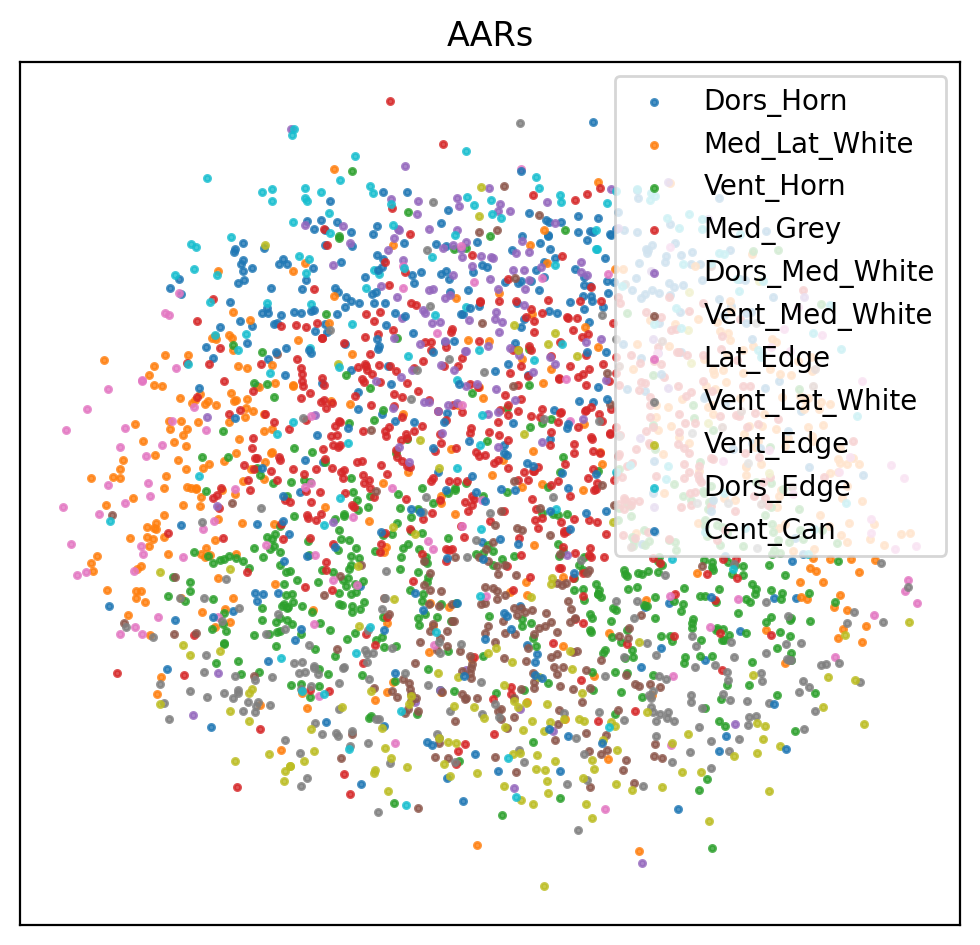

In [4]:
plot_annotations_in_common_coordinate_system(splotch_input_data);

In [5]:
splotch_input_data.metadata.groupby(
    ["level_1", "level_2", "level_3"], observed=True
).size().reset_index(name="num_spots").head()

level_1 level_2 level_3  num_spots
0  G93A p120       F    1394        427
1  G93A p120       M     975        573
2    WT p120       F    1040        440
3    WT p120       M    1310        464
4    WT p120       M    2967        570

In [6]:
splotch_input_data.metadata.groupby(
    ["level_1", "level_2", "level_3", "aar"], observed=True
).size().reset_index(name="num_spots").head()

level_1 level_2 level_3             aar  num_spots
0  G93A p120       F    1394        Cent_Can         37
1  G93A p120       F    1394       Dors_Edge         22
2  G93A p120       F    1394       Dors_Horn         42
3  G93A p120       F    1394  Dors_Med_White         32
4  G93A p120       F    1394        Lat_Edge         13

## NUTS

In [7]:
key = random.PRNGKey(0)
key, key_ = random.split(key)

splotch_result_nuts = run_nuts(
    key_,
    ["Gfap", "Slc5a7"],
    splotch_input_data,
    map_method="pmap",
    num_warmup=1_000,
    num_samples=1_000,
    num_chains=4,
)

2023-12-15 19:46:10.385428: E external/xla/xla/service/collective_ops_utils.h:260] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{rank=3, element_count=9896000, type=F32, rendezvous_key=RendezvousKey{run_id=RunId: 18356, global_devices=[0,1,2,3], num_local_participants=4, collective_op_kind=cross_replica, op_id=523}} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 18356, global_devices=[0,1,2,3], num_local_participants=4, collective_op_kind=cross_replica, op_id=523}
2023-12-15 19:46:11.505832: E external/xla/xla/service/collective_ops_utils.h:263] Thread is unstuck! Warning above was a false-positive. Perhaps the timeout is too short: participant AllReduceParticipantData{rank=3, element_count=9896000, type=F32, rendezvous_key=RendezvousKey{run_id=RunId: 18356, global_devices=[0,1,2,3], num_local_participants=4, collective_op_kind=cross_replica, op_id=523}} waiting for all participants to arrive at rend

In [8]:
pd.concat(
    [
        splotch_result_nuts.inference_metrics["summary"][k].query("r_hat > 1.05")
        for k in splotch_result_nuts.inference_metrics["summary"]
    ],
    axis=0,
)

Empty DataFrame
Columns: [mean, std, median, 5.0%, 95.0%, n_eff, r_hat]
Index: []

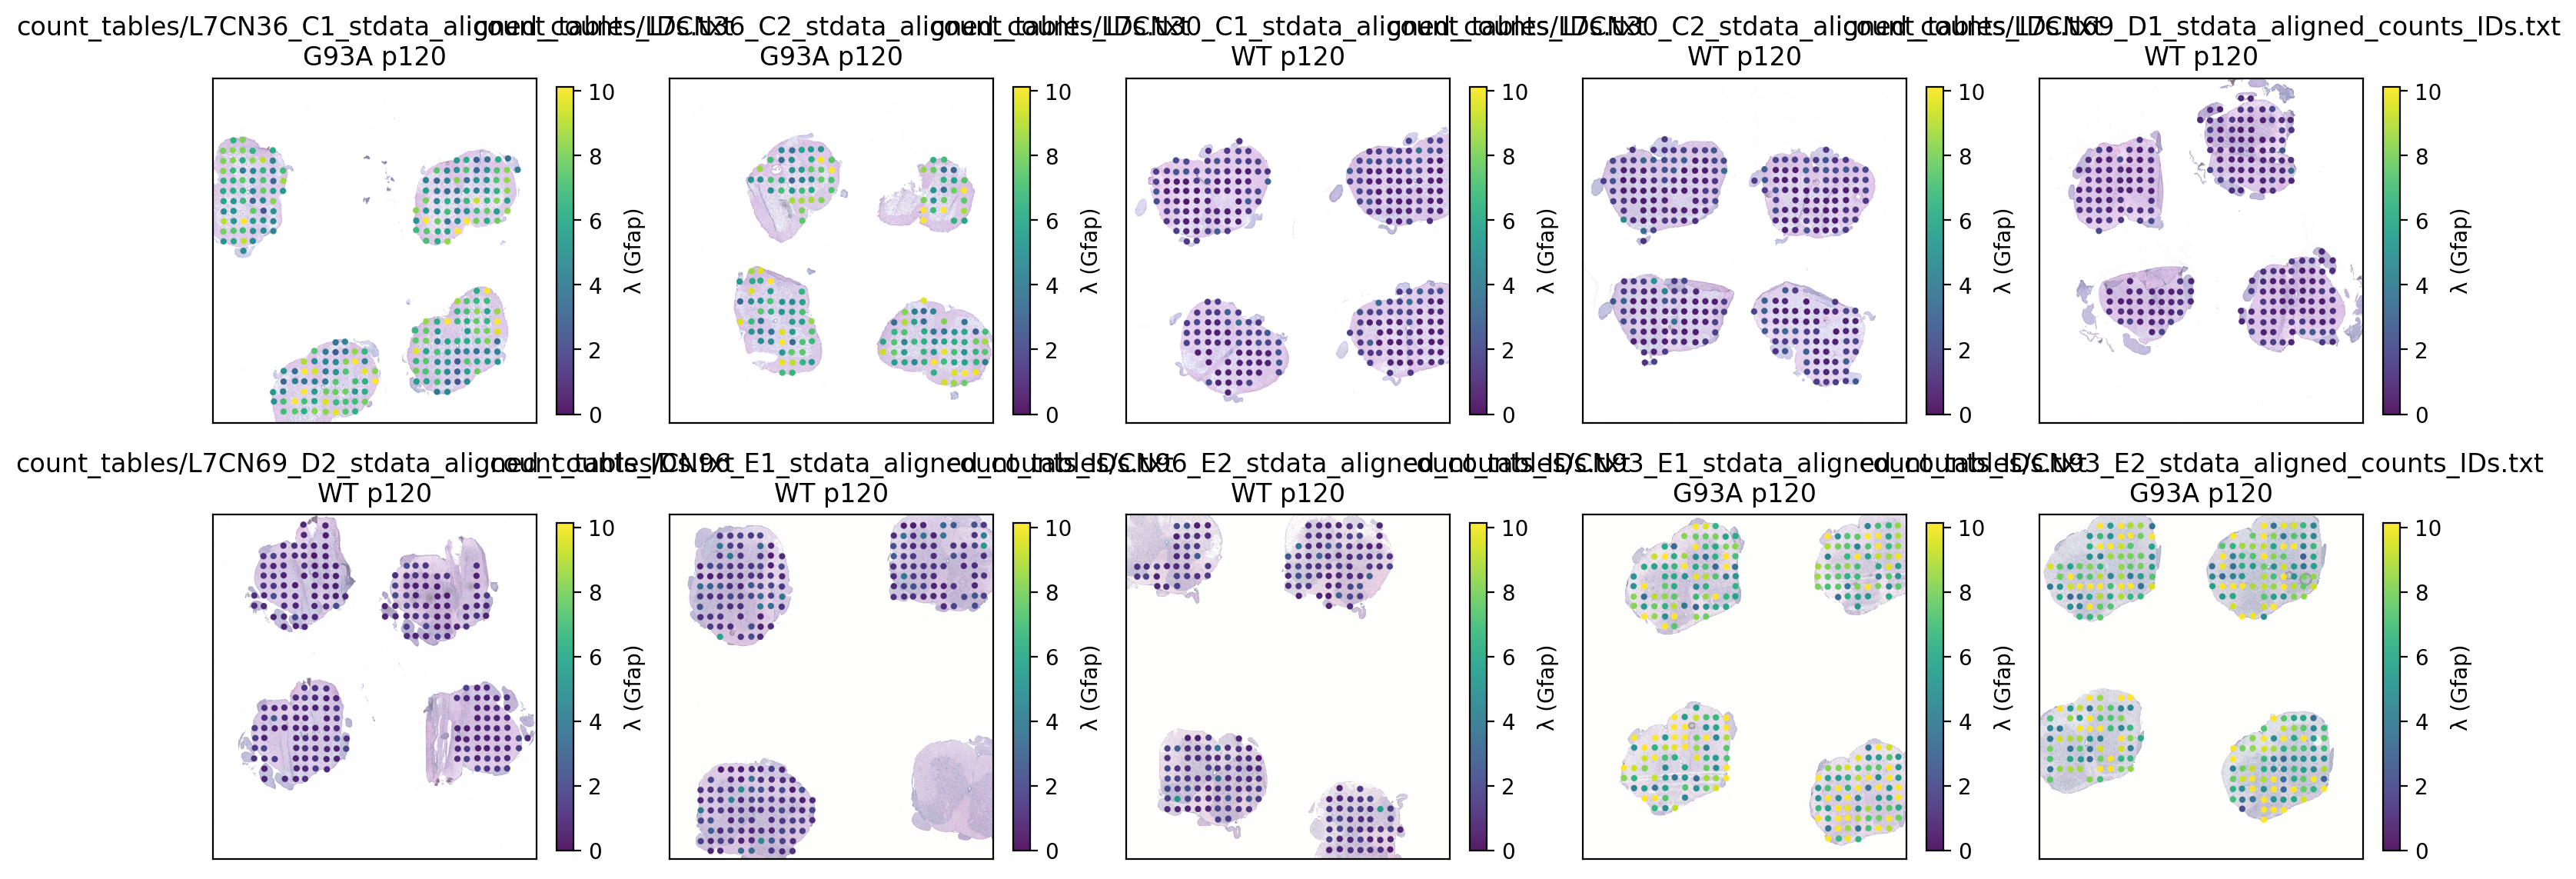

In [9]:
gene = "Gfap"

plot_rates_on_slides(splotch_result_nuts, gene);

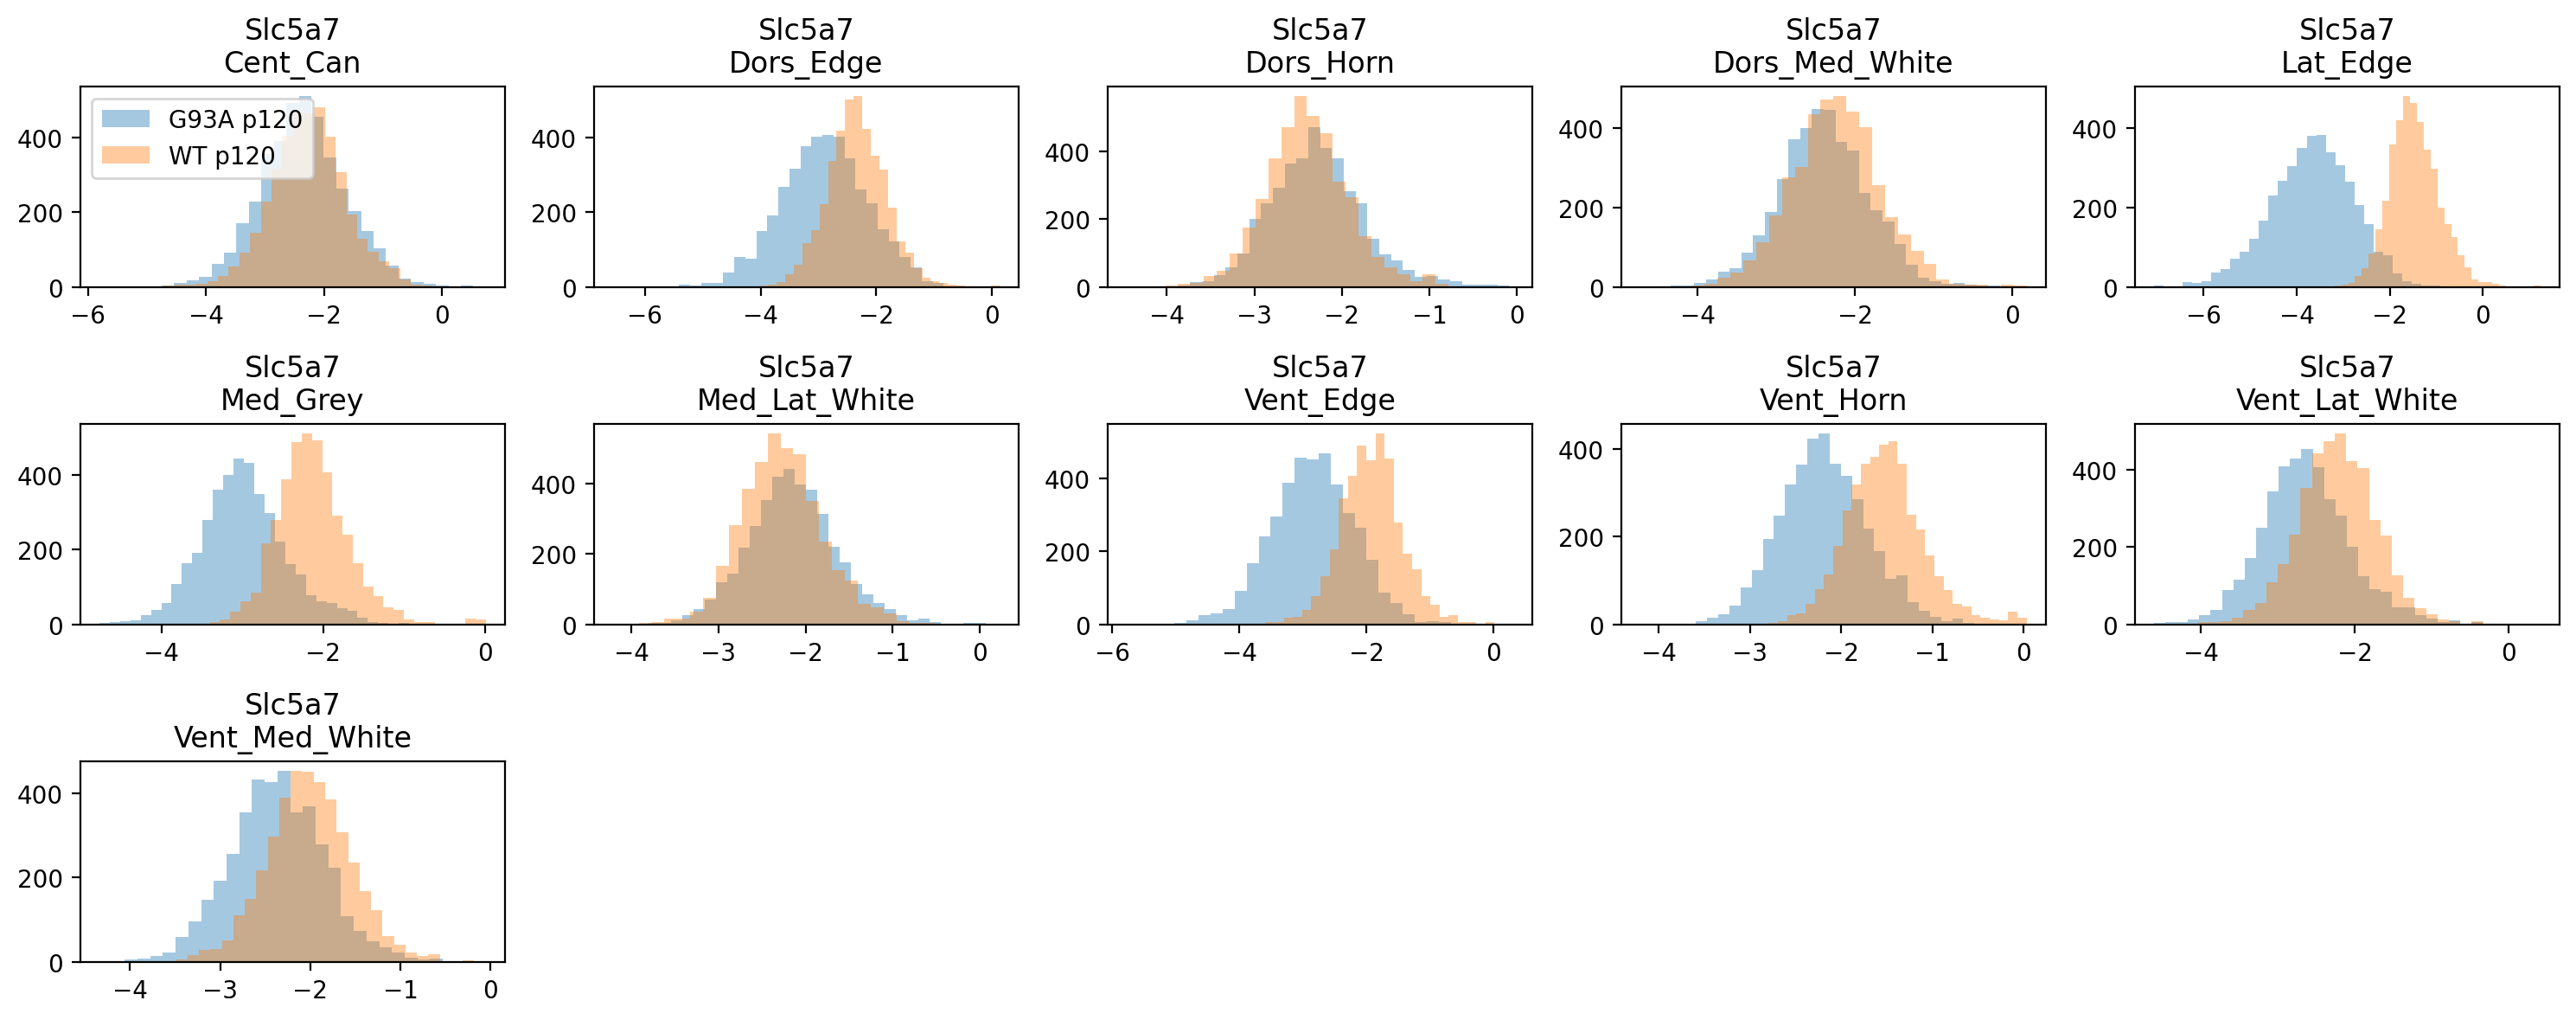

In [10]:
gene = "Slc5a7"

plot_coefficients(splotch_input_data, splotch_result_nuts, gene);

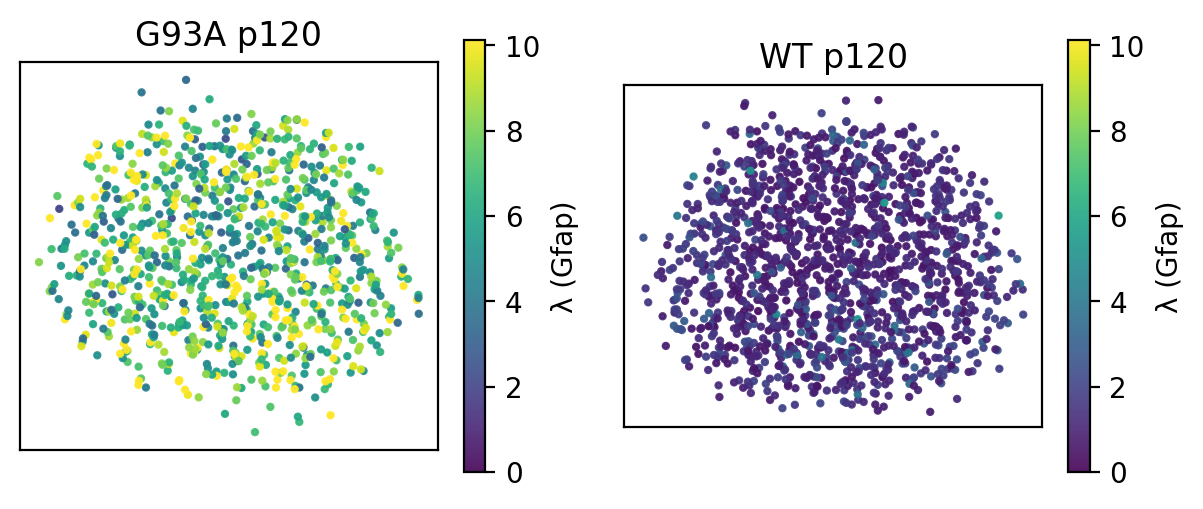

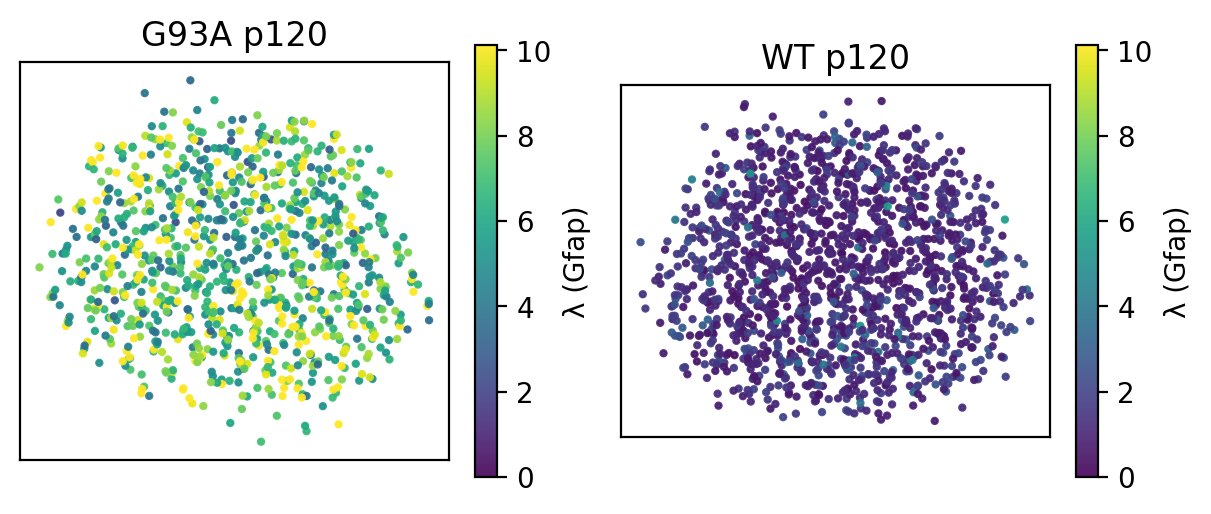

In [11]:
gene = "Gfap"

plot_rates_in_common_coordinate_system(splotch_result_nuts, gene)

## SVI

In [12]:
key = random.PRNGKey(0)
key, key_ = random.split(key)
splotch_result_svi = run_svi(
    key,
    ["Gfap", "Slc5a7"],
    splotch_input_data,
    map_method="map",
    num_steps=10_000,
    num_samples=1_000,
)

Text(0.5, 0, 'Iteration')

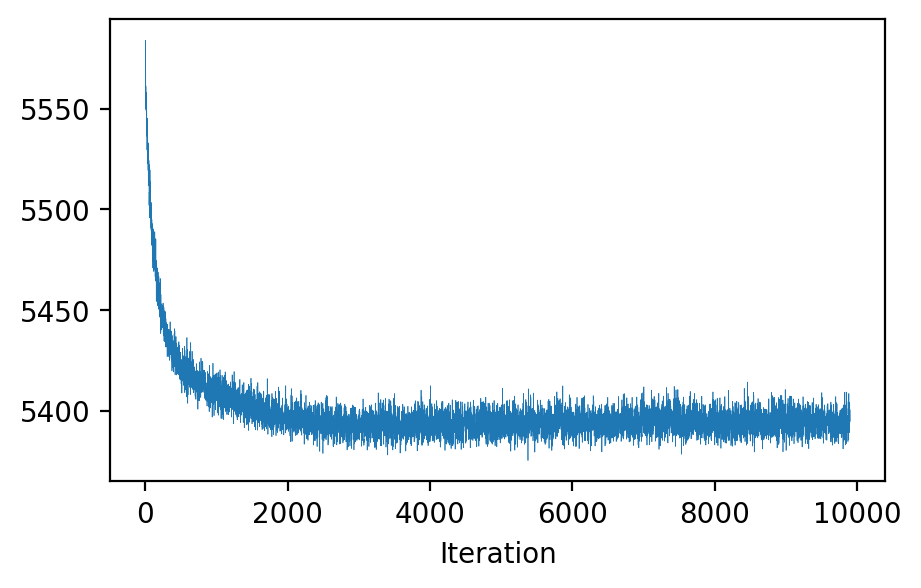

In [13]:
fig = plt.figure()
fig.set_size_inches(5, 3)

ax = fig.add_subplot(1, 1, 1)

ax.plot(splotch_result_svi.inference_metrics["losses"][0, 100:], lw=0.25)
ax.set_xlabel("Iteration")

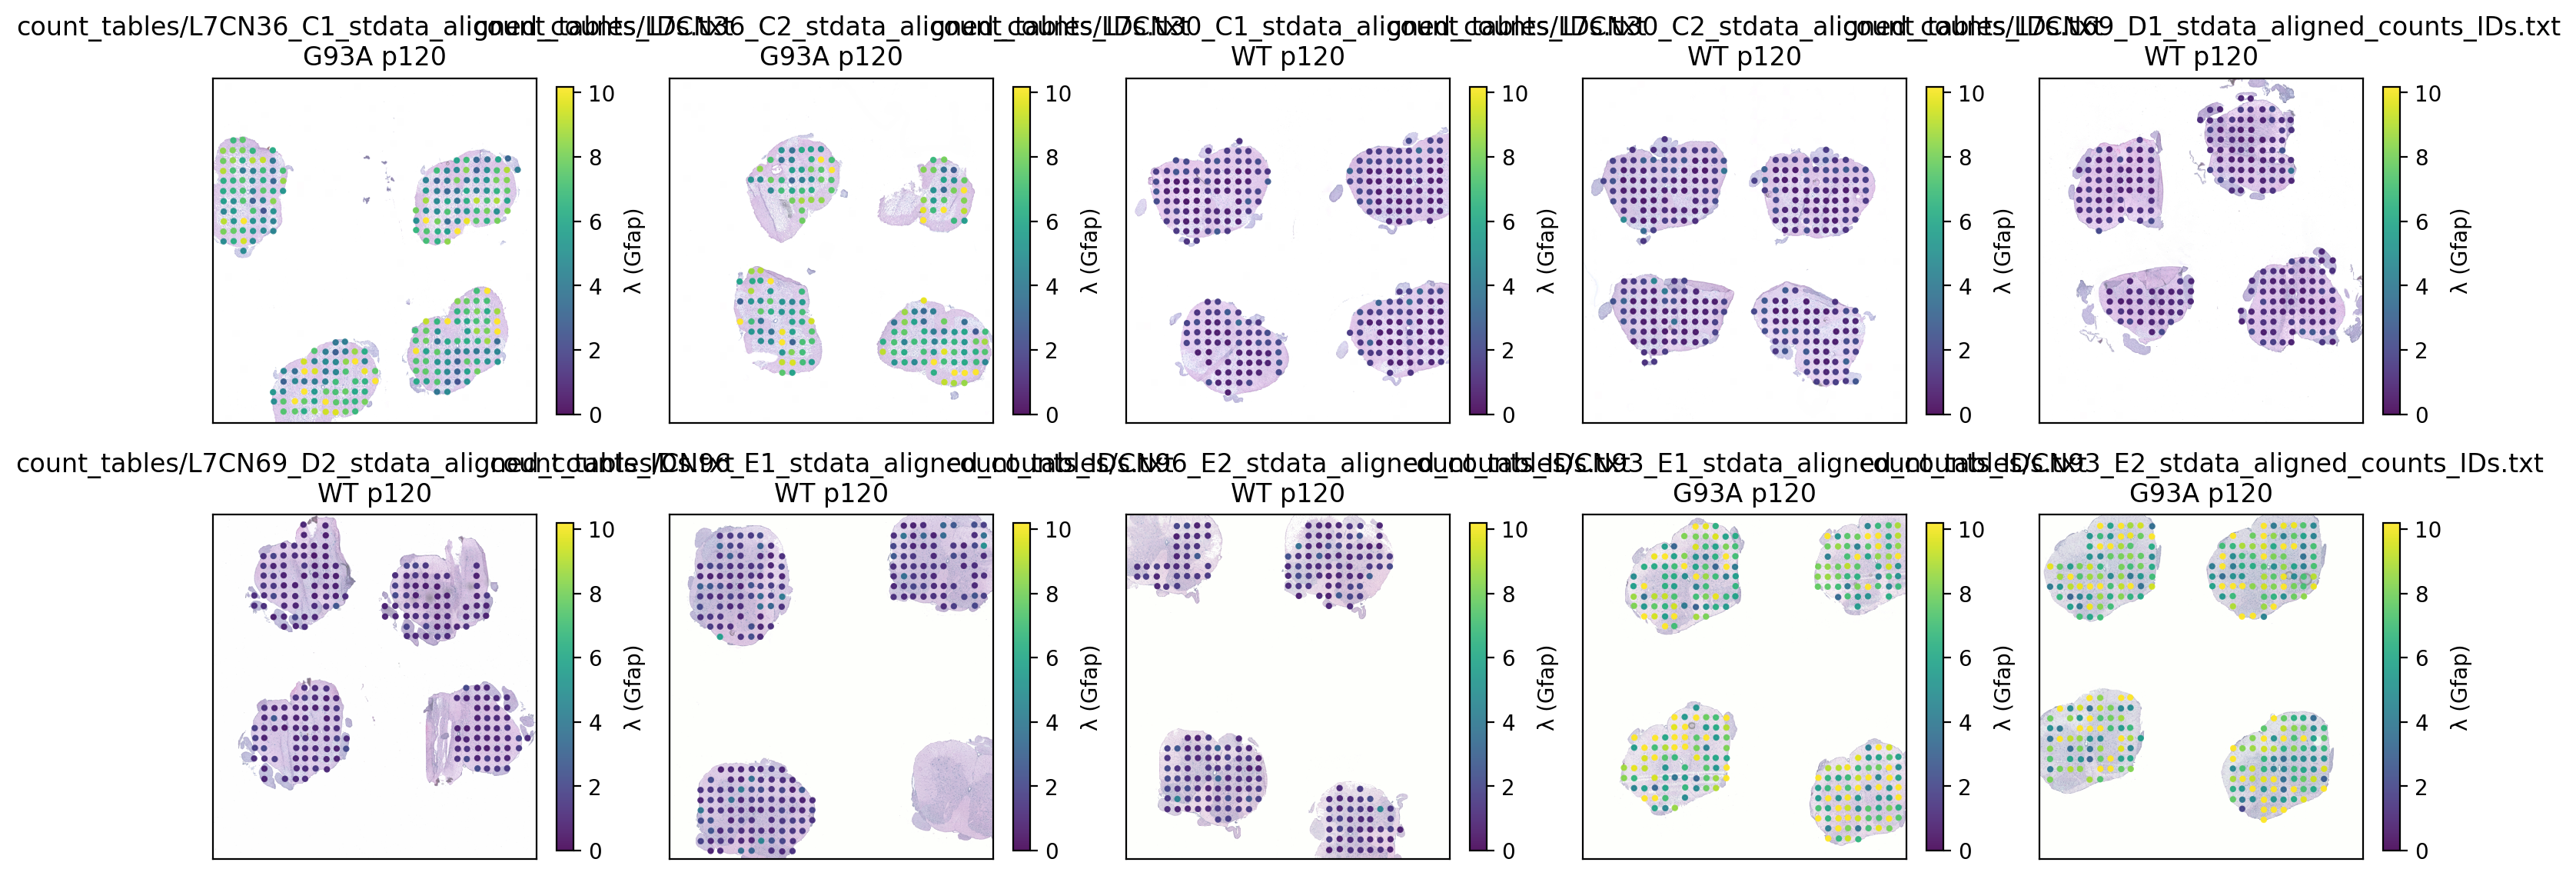

In [14]:
gene = "Gfap"

plot_rates_on_slides(splotch_result_svi, gene);

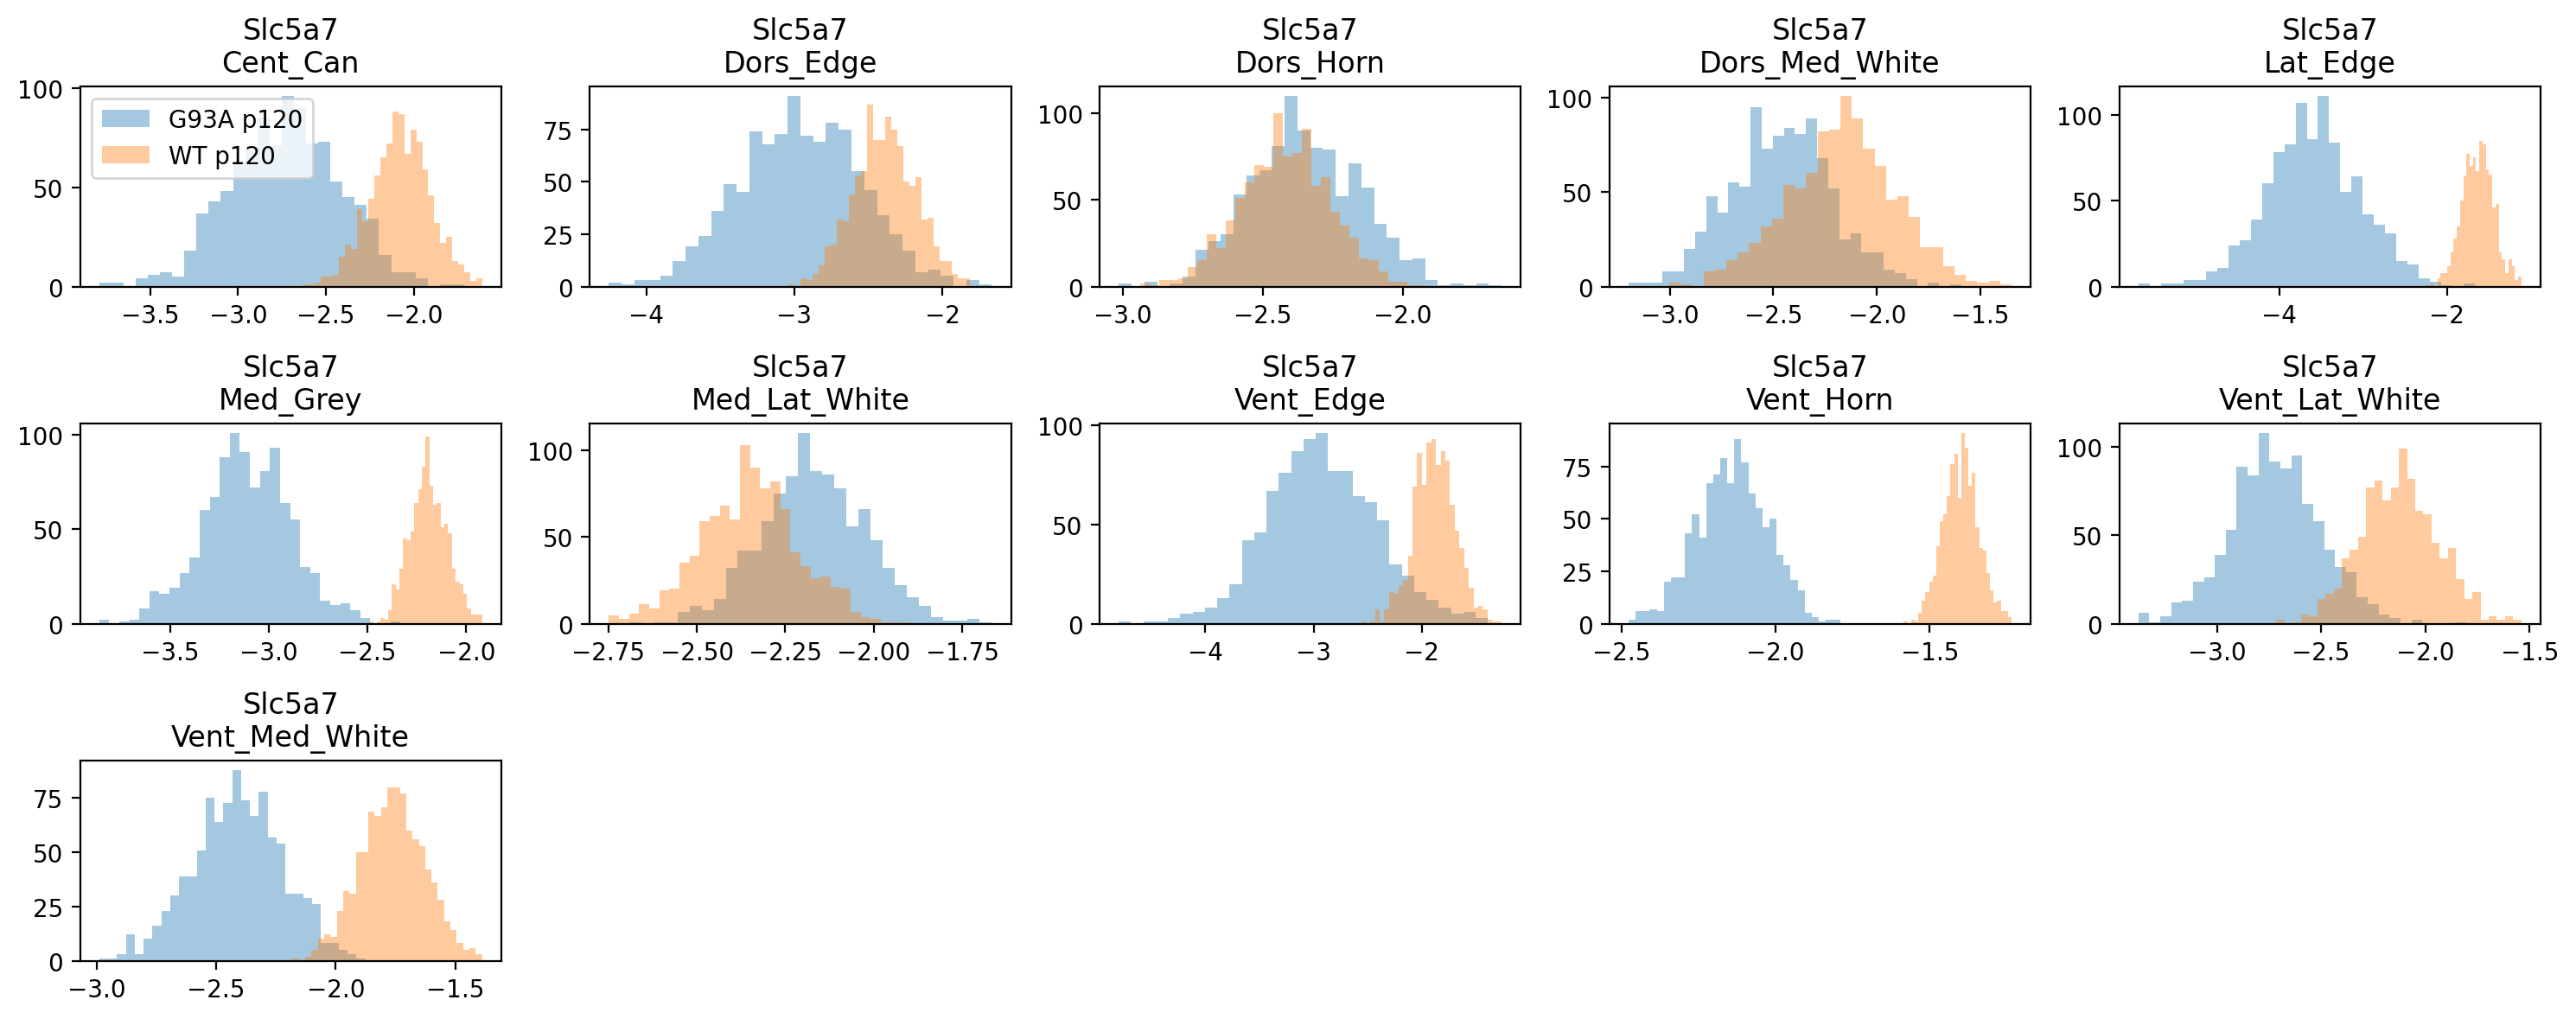

In [15]:
gene = "Slc5a7"

plot_coefficients(splotch_input_data, splotch_result_svi, gene);

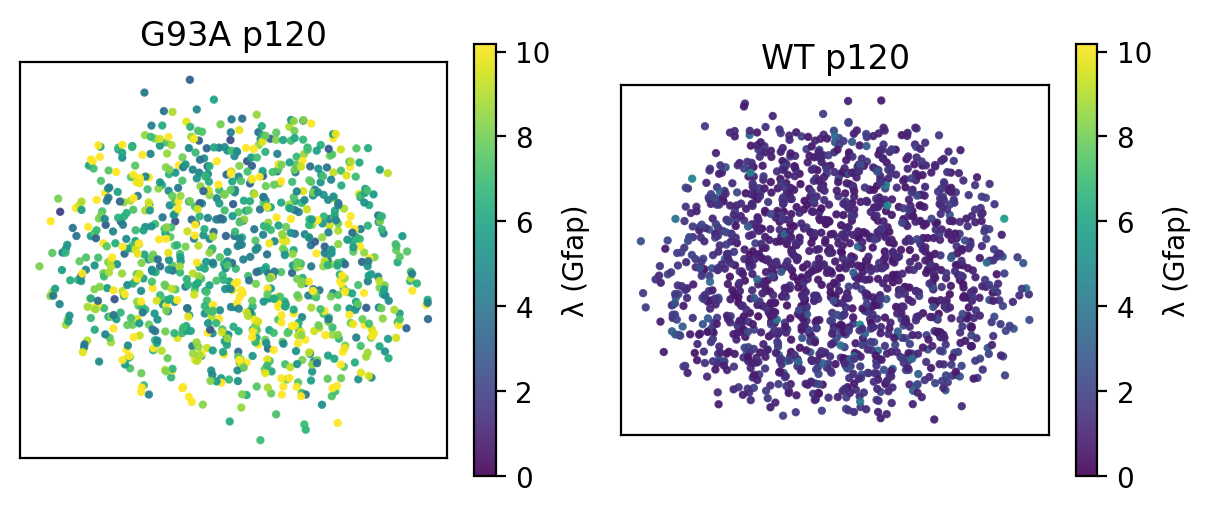

In [16]:
gene = "Gfap"

plot_rates_in_common_coordinate_system(splotch_result_svi, gene);